In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Multiclass classification means a classification task with more than two classes; e.g., classify a set of images of fruits which may be oranges, apples, or pears. Multiclass classification makes the assumption that each sample is assigned to one and only one label: a fruit can be either an apple or a pear but not both at the same time.

Multilabel classification assigns to each sample a set of target labels. This can be thought of as predicting properties of a data-point that are not mutually exclusive, such as topics that are relevant for a document. A text might be about any of religion, politics, finance or education at the same time or none of these.

Taken from http://scikit-learn.org/stable/modules/multiclass.html

In [ ]:
import ast # used to make columns of dictionnary's keys 
# used for safely evaluating strings containing Python values from untrusted sources without the need to parse the values oneself

import matplotlib.pyplot as plt # Library for data visualization
import seaborn as sns
import plotly.graph_objs as go

import re # Library to use Regular Expressions


import nltk
from nltk.corpus import stopwords # Nltk is used to remove stopwords from our descriptions data
import gensim # open-source library for unsupervised topic modeling and NLP
from gensim.utils import simple_preprocess # Convert a document into a list of tokens

from sklearn.feature_extraction.text import TfidfVectorizer # Library used to apply TF-IDF word embedding

from sklearn.model_selection import train_test_split # Used to split the dataset (train/val)


## Training models

# Statistical models
from skmultilearn.problem_transform import LabelPowerset
from sklearn.linear_model import LogisticRegression

from skmultilearn.adapt import MLkNN # Implementation of KNN for multi label classification tasks
from scipy.sparse import csr_matrix, lil_matrix
from sklearn.preprocessing import MultiLabelBinarizer

from skmultilearn.problem_transform import ClassifierChain

# EVALUATION METRICS
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score

### Loading the different subgenres dataset

In [ ]:
aliens_df = pd.read_csv('../input/science-fiction-books-subgenres/sf_aliens.csv')

alternate_history_df = pd.read_csv('../input/science-fiction-books-subgenres/sf_alternate_history.csv')

alternate_universe_df = pd.read_csv('../input/science-fiction-books-subgenres/sf_alternate_universe.csv')

apocalyptic_df = pd.read_csv('../input/science-fiction-books-subgenres/sf_apocalyptic.csv')

cyberpunk_df = pd.read_csv('../input/science-fiction-books-subgenres/sf_cyberpunk.csv')

dystopia_df = pd.read_csv('../input/science-fiction-books-subgenres/sf_dystopia.csv')

hard_sf_df = pd.read_csv('../input/science-fiction-books-subgenres/sf_hard.csv')

military_sf_df = pd.read_csv('../input/science-fiction-books-subgenres/sf_military.csv')

robots_df = pd.read_csv('../input/science-fiction-books-subgenres/sf_robots.csv')

space_opera_df = pd.read_csv('../input/science-fiction-books-subgenres/sf_space_opera.csv')

steampunk_df = pd.read_csv('../input/science-fiction-books-subgenres/sf_steampunk.csv')

time_travel_df = pd.read_csv('../input/science-fiction-books-subgenres/sf_time_travel.csv')

### Defining a function to extract the genres from the "Genres" column of a dataset

In [ ]:
def extract_genres(raw_df):
    raw_df['Genres'] = raw_df['Genres'].map(lambda d : ast.literal_eval(d))
    genres_df = pd.DataFrame(raw_df["Genres"].to_dict()).T
    genres_df = genres_df.fillna(0)
    return genres_df

### Defining a function to make binaries from every genre data

We filter the subgenres by a minimum number of 5 people that tagged (we collected this information before) a book to reduce the bias of subjectivity introduced by human filled data.

In [ ]:
# We transform every value in genres dataset > 0 to 1 

def binary_genres(genres_df):
    df_cols = list(genres_df.columns)
    for i in df_cols:
        genres_df.loc[genres_df[i] <= 5, i] = 0
        genres_df.loc[genres_df[i] > 5, i] = 1

    return genres_df

### We define a function that use the two others and select a subset of genres

In [ ]:
def select_binary_sf_subgenres(raw_df, sf_cols):
    genres_df = extract_genres(raw_df)
    genres_df = genres_df[sf_cols].copy()
    genres_df = binary_genres(genres_df)
    return genres_df

## Datasets SF Subgenres Exploration

While exploring the different genres SF subsets, we will need to select some genres and sometimes exclude others.

In [ ]:
sf_cols = ['Science Fiction (Dystopia) ',
         'Science Fiction (Time Travel) ',
         'Science Fiction (Cyberpunk) ',
         'Science Fiction (Robots) ',
         'Science Fiction (Aliens) ',
         'Science Fiction (Apocalyptic) ',
         'Science Fiction (Alternate History) ',
         'Science Fiction (Hard Science Fiction) ',
         'Science Fiction (Steampunk) ',
         'Science Fiction (Military Science Fiction) ',
         'Space (Space Opera) ']

sf_cols_apo = ['Science Fiction (Dystopia) ',
         'Science Fiction (Time Travel) ',
         'Science Fiction (Cyberpunk) ',
         'Science Fiction (Robots) ',
         'Science Fiction (Aliens) ',
         'Science Fiction (Apocalyptic) ',
         'Science Fiction (Alternate History) ',
         'Science Fiction (Hard Science Fiction) ',
         'Science Fiction (Steampunk) ',
         'Space (Space Opera) ']

sf_cols_alt_u = ['Science Fiction (Dystopia) ',
         'Science Fiction (Time Travel) ',
         'Science Fiction (Alternate Universe) ',
         'Science Fiction (Cyberpunk) ',
         'Science Fiction (Robots) ',
         'Science Fiction (Aliens) ',
         'Science Fiction (Apocalyptic) ',
         'Science Fiction (Alternate History) ',
         'Science Fiction (Hard Science Fiction) ',
         'Science Fiction (Steampunk) ',
         'Science Fiction (Military Science Fiction) ',
         'Space (Space Opera) ']



sf_cols_dyst = ['Science Fiction (Dystopia) ',
 'Science Fiction (Time Travel) ',
 'Science Fiction (Cyberpunk) ',
 'Science Fiction (Robots) ',
 'Science Fiction (Aliens) ',
 'Science Fiction (Apocalyptic) ',
 'Science Fiction (Alternate History) ',
 'Science Fiction (Steampunk) ',
 'Space (Space Opera) ']

sf_cols_tt = ['Science Fiction (Dystopia) ',
         'Science Fiction (Time Travel) ',
         'Science Fiction (Cyberpunk) ',
         'Science Fiction (Aliens) ',
         'Science Fiction (Apocalyptic) ',
         'Science Fiction (Alternate History) ',
         'Science Fiction (Hard Science Fiction) ',
         'Science Fiction (Steampunk) ',
         'Science Fiction (Military Science Fiction) ',
         'Space (Space Opera) ']



sf_cols_None = ['Science Fiction (Dystopia) ',
 'Science Fiction (Time Travel) ',
 'Science Fiction (Cyberpunk) ',
 'Science Fiction (Robots) ',
 'Science Fiction (Aliens) ',
 'Science Fiction (Apocalyptic) ',
 'Science Fiction (Alternate History) ',
 'Science Fiction (Hard Science Fiction) ',
 'Science Fiction (Steampunk) ',
 'Science Fiction (Military Science Fiction) ',
 'Space (Space Opera) ',
               'None']

## Aliens df subgenres distribution

In [ ]:
aliens_subgenres_df = select_binary_sf_subgenres(aliens_df, sf_cols)
plt.figure(figsize=(16,8))
aliens_subgenres_df.sum(axis=0).plot.bar()

The Aliens subgenre dataset mainly contains Aliens assigned books, it can be a main SF subgenre in itself. 
Sometimes dystopia and/or space opera are also assigned, this makes sense.

According to goodreads:
>Aliens are extraterrestrial life that does not originate from Earth. The sentient beings can range from simple bacteria-life organisms to complex species and individuals. Aliens are used in a variety of genres, most notably Science-Fiction.

### Alternate History df subgenres distribution

In [ ]:
alternate_history_subgenres_df = select_binary_sf_subgenres(alternate_history_df, sf_cols)
plt.figure(figsize=(16,8))
alternate_history_subgenres_df.sum(axis=0).plot.bar()

The Alternate History subgenre dataset mainly contains Alternate History assigned books, it can be a main SF subgenre in itself. 
Sometimes dystopia and/or time-travel and/or Steampunk are also assigned, this makes sense.

According to goodreads:
> Alternate history is a subgenre of speculative fiction (or science fiction) and historical fiction that is set in a world in which history has diverged from the actual history of the world. Alternate history literature asks the question, "What if history had developed differently?" Most works in this genre are based on real historical events, yet feature social, geopolitical, or industrial circumstances that developed differently than our own. 

### Alternate Universe df subgenres distribution

In [ ]:
alternate_universe_subgenres_df = select_binary_sf_subgenres(alternate_universe_df, sf_cols_alt_u)
plt.figure(figsize=(16,8))
alternate_universe_subgenres_df.sum(axis=0).plot.bar()

Looking at the distribution plot of the subgenres, we can not conclude that alternate universe is a subgenre of SF in itself.
By nature Alternate Universe is only a composition of other subgenres (mainly dystopia, alternate-history, steampunk and time-travel).

This can be explained by the fact that alternate universe is mainly used in fantasy books while in SF we prefer to speak about alternate history.

### Apocalyptic df subgenres distribution

In [ ]:
apocalyptic_subgenres_df = select_binary_sf_subgenres(apocalyptic_df, sf_cols_apo)
plt.figure(figsize=(16,8))
apocalyptic_subgenres_df.sum(axis=0).plot.bar()

The Apocalyptic subgenre dataset mainly contains Dystopia and Apocalyptic assigned books, since apocalyptic contains dystopia but dystopia doesn't imperatively contains it, so it can be a sub SF subgenre in itself. 

According to goodreads:
>Apocalyptic is from the word apocalypse, referring to the end of the world.
Apocalyptic fiction focuses on the end of civilization either through nuclear war, plague, or other global catastrophic risk.
Apocalyptic literature is a genre of religious writing centered on visions of the end of time.
Many apocalyptic stories focus on stories that are on the brink of the end of the world of the civilization. Post-apocalyptic fiction is set in a world or civilization after such a disaster. 


### Cyberpunk df subgenres distribution

In [ ]:
cyberpunk_subgenres_df = select_binary_sf_subgenres(cyberpunk_df, sf_cols)
plt.figure(figsize=(16,8))
cyberpunk_subgenres_df.sum(axis=0).plot.bar()

The Cyberpunk subgenre dataset mainly contains Cyberpunk assigned books, it can be a main SF subgenre in itself. 
Dystopia is heavy linked with Cyberpunk, this makes sense.

According to goodreads:
>Cyberpunk is a subgenre of science fiction in a future setting that tends to focus on society as "high tech low life" featuring advanced technological and scientific achievements, such as information technology and cybernetics, juxtaposed with a degree of breakdown or radical change in the social order.
Cyberpunk plots often center on conflict among artificial intelligences, hackers, and among megacorporations, and tend to be set in a near-future Earth, rather than in the far-future settings or galactic vistas found in novels such as Isaac Asimov's Foundation or Frank Herbert's Dune. The settings are usually post-industrial dystopias but tend to feature extraordinary cultural ferment and the use of technology in ways never anticipated by its original inventors ("the street finds its own uses for things"). Much of the genre's atmosphere echoes film noir, and written works in the genre often use techniques from detective fiction.
Classic cyberpunk characters were marginalized, alienated loners who lived on the edge of society in generally dystopic futures where daily life was impacted by rapid technological change, an ubiquitous datasphere of computerized information, and invasive modification of the human body

### Dystopia df subgenres distribution

In [ ]:
dystopia_subgenres_df = select_binary_sf_subgenres(dystopia_df, sf_cols_dyst)
plt.figure(figsize=(16,8))
dystopia_subgenres_df.sum(axis=0).plot.bar()

The Dystopia subgenre dataset mainly contains Dystopia assigned books, it can be a main SF subgenre in itself. 

According to goodreads:
>Dystopia is a form of literature that explores social and political structures. It is a creation of a nightmare world - unlike its opposite, Utopia, which is an ideal world.
Dystopia is often characterized by an authoritarian or totalitarian form of government. It often features different kinds of repressive social control systems, a lack or total absence of individual freedoms and expressions, and a state of constant warfare or violence.
Many novels combine both Dystopia and Utopia, often as a metaphor for the different directions humanity can take in its choices, ending up with one of the two possible futures.
Dystopia is very similar to False Utopia, but but instead of the often visibly oppressive and/or anarchic "true" Dystopia, a False Utopia appears inviting at first and indeed may well be a nice place to live in but hides a dark and often terrible secret beneath its innocent exterior.

### Hard SF df subgenres distribution

In [ ]:
hard_sf_subgenres_df = select_binary_sf_subgenres(hard_sf_df, sf_cols)
plt.figure(figsize=(16,8))
hard_sf_subgenres_df.sum(axis=0).plot.bar()

With only ~250 books assigned to Hard SF and a lot more to space opera, I will not retain Hard SF as a main subgenre of SF.

According to goodreads:
> Hard science fiction is a category of science fiction characterized by an emphasis on scientific or technical detail, or on scientific accuracy, or on both. It is characterized by rigorous attention to accurate detail in the natural sciences, especially physics, astrophysics, and chemistry, or on accurately depicting worlds that more advanced technology may make possible. Hard science fiction is driven more by ideas than characterization. Plausible science and technology are central to the plot.

### Military SF df subgenres distribution

In [ ]:
military_sf_subgenres_df = select_binary_sf_subgenres(military_sf_df, sf_cols)
plt.figure(figsize=(16,8))
military_sf_subgenres_df.sum(axis=0).plot.bar()

Military sf is heavily linked to space opera but we will try to consider it as a subgenre in itself.

According to goodreads:
>Military science fiction is a subgenre of science fiction that features the use of science fiction technology, mainly weapons, for military purposes and usually principal characters that are members of a military organization involved in military activity; occurring sometimes in outer space or on a different planet or planets. It exists in literature, comics, film and video games.
A detailed description of the conflict, the tactics and weapons used for it, and the role of a military service and the individual members of that military organization forms the basis for a typical work of military science fiction. The stories often use features of actual past or current Earth conflicts, with countries being replaced by planets or galaxies of similar characteristics, battleships replaced by space battleships and certain events changed so that the author can extrapolate what might have occurred.

## Robots df subgenres distribution

In [ ]:
robots_subgenres_df = select_binary_sf_subgenres(robots_df, sf_cols)
plt.figure(figsize=(16,8))
robots_subgenres_df.sum(axis=0).plot.bar()

Robots look like a small subgenre of SF but still a subgenre in itself, though heavily linked to dystopia.

According to goodreads:
> A robot is a machine—especially one programmable by a computer—capable of carrying out a complex series of actions automatically. Robots can be guided by an external control device or the control may be embedded within. Robots may be constructed to take on human form but most robots are machines designed to perform a task with no regard to how they look.


## Space Opera df subgenres distribution

In [ ]:
space_opera_subgenres_df = select_binary_sf_subgenres(space_opera_df, sf_cols)
plt.figure(figsize=(16,8))
space_opera_subgenres_df.sum(axis=0).plot.bar()

The Space Opera subgenre dataset mainly contains Space Opera assigned books, it can be a main SF subgenre in itself. 
Sometimes Military SF and/or Aliens are also assigned, this makes sense.

>Space opera is a subgenre of speculative fiction or science fiction that emphasizes romantic, often melodramatic adventure, set mainly or entirely in space, generally involving conflict between opponents possessing powerful (and sometimes quite fanciful) technologies and abilities. Perhaps the most significant trait of space opera is that settings, characters, battles, powers, and themes tend to be very large-scale.

## Steam Punk df subgenres distribution

In [ ]:
steampunk_subgenres_df = select_binary_sf_subgenres(steampunk_df, sf_cols_dyst)
plt.figure(figsize=(16,8))
steampunk_subgenres_df.sum(axis=0).plot.bar()

Steampunk seems to be a main subgenre of SF in itself, sometimes linked to alternate-history and dystopia.

According to goodreads:
>Steampunk is a subgenre of speculative fiction, usually set in an anachronistic Victorian or quasi-Victorian alternate history setting. It could be described by the slogan "What the past would look like if the future had happened sooner." The term denotes works set in an era or world where STEAM POWER is still widely used—usually the 19th century, and often set in Victorian era England—but with prominent elements of either science fiction or fantasy, such as fictional technological inventions like those found in the works of H. G. Wells and Jules Verne, or real technological developments like the computer occurring at an earlier date.
It is a subgenre of fantasy and speculative fiction that came into prominence in the 1980s and early 1990s.
Dieselpunk takes over where Steampunk leaves off. These are stories that take over as we usher in the machine-heavy eras of WWI and WWII. The use of diesel-powered machines plays heavily. In this (like its steam counterpart), the focus is on the technology.

## Time Travel df subgenres distribution

In [ ]:
time_travel_subgenres_df = select_binary_sf_subgenres(time_travel_df, sf_cols_tt)
plt.figure(figsize=(16,8))
time_travel_subgenres_df.sum(axis=0).plot.bar()

Time travel seems well suited to be a subgenre in itself.

According to goodreads:
>Time travel is the concept of moving between different points in time in a manner analogous to moving between different points in space. Time travel could hypothetically involve moving backward in time to a moment earlier than the starting point, or forward to the future of that point without the need for the traveler to experience the intervening period (at least not at the normal rate). Time travel can form the central theme of a book or it can simply be a plot device to drive a story. Time travel in fiction can ignore the possible effects of the time traveler's actions or it can explote its repercussions (ie: paradoxes).

### Conclusion of this subgenre exploration:
* Aliens is a genre in itself
* Alternate History is a genre in itself
* **Alternate Universe is not a genre in itself**
* Apocalyptic is a genre in itself
* Cyberpunk is a genre in itself
* Dystopia is a genre in itself
* **Hard SF is not a genre in itself**
* Military SF is a genre in itself
* Robots is a genre in itself
* Space Opera is a genre in itself
* Steampunk is a genre in itself
* Time Travel is a genre in itself

In [ ]:
# We only keep the SF subgenres we identified as plain subgenres.
# We add None to exclude the books classified in no subgenres (by the website) in the future.

sf_cols = ['Science Fiction (Dystopia) ',
         'Science Fiction (Time Travel) ',
         'Science Fiction (Cyberpunk) ',
         'Science Fiction (Robots) ',
         'Science Fiction (Aliens) ',
         'Science Fiction (Apocalyptic) ',
         'Science Fiction (Alternate History) ',
         'Science Fiction (Steampunk) ',
         'Science Fiction (Military Science Fiction) ',
         'Space (Space Opera) ',
          'None']

In [ ]:
real_subgenres = [aliens_df, alternate_history_df, apocalyptic_df, cyberpunk_df, dystopia_df, military_sf_df,
                  robots_df, space_opera_df, steampunk_df, time_travel_df]

# We concat all subgenres datasets to create a new dataset with all identified subgenres
sf_df = pd.concat(real_subgenres)

sf_df

## Cleaning our new dataset

### Dropping url (meaning books) that appeared several times over the different subgenres dataset 

In [ ]:
sf_df = sf_df.drop_duplicates(subset='url', keep='first', inplace=False)
sf_df

In [ ]:
sf_df = sf_df.reset_index().drop('index', axis=1)
sf_df

In [ ]:
sf_df = sf_df.reset_index().drop('index', axis=1)
sf_df

### We extract subgenres from our new dataset

In [ ]:
sf_df = sf_df.reset_index().drop('index', axis=1)

sf_subgenres_df = pd.DataFrame(sf_df["Genres"].to_dict()).T
sf_subgenres_df = sf_subgenres_df.fillna(0)
sf_subgenres_df = sf_subgenres_df[sf_cols].copy()
sf_subgenres_df = binary_genres(sf_subgenres_df)

plt.figure(figsize=(16,8))
sf_subgenres_df.sum(axis=0).plot.bar()

### We combine the two datasets in one

In [ ]:
sf_full = pd.concat([sf_df, sf_subgenres_df], axis=1)

### Make some data exploration about the subgenres published these 20 last years

In [ ]:
table = pd.pivot_table(sf_full, values=sf_cols, index=['Year_published'],
                    aggfunc=np.sum)

In [ ]:
table_2000 = table[95:105]
table_2010 = table[105:115]
table_2000_2020 = table[95:115]

In [ ]:
plt.figure(figsize=(40,20))
table_2000_2020.plot.line()

## Preprocessing the data

In [ ]:
sf_full.isna().sum()

In [ ]:
# Getting rid of NaNs in book description
sf_full.dropna(subset = ["Book_Description"], inplace=True)
# Replacing NaNs
sf_full.Edition_Language = sf_full.Edition_Language.fillna('None')

In [ ]:
# Verifying that Nans have successfully been processed
sf_full.isna().sum()

### Getting rid of foreing edition books (resulting in non-english book description)

In [ ]:
sf_full = sf_full[sf_full['Edition_Language'].isin(['English', 'None'])]
sf_full

### Getting rid of reluctant foreign language book descriptions

In [ ]:
#pd.options.display.max_rows = 999
#sf_full[sf_full['Book_Description'].str.contains(' el ')]
sf_full = sf_full.drop([410, 3202, 7421, 8079], axis=0)
# 410 fr
# 3202 nl
# 7421 es
# 8079 it

### Getting rid of Nones genres
As indicated in the metadata of the dataset, the books with the "None" key in the genres dictionnary are books that are assigned to no genres, meaning that they could in reality belong to any genre. 

Thus, keeping them will just add noise to our model and that's not what we want. 

In [ ]:
sf_full = sf_full[sf_full['None'] < 1]
sf_full =  sf_full.drop('None', axis = 1)
sf_cols.pop()
sf_full

In [ ]:
sf_full = sf_full.drop([1838, 5461], axis=0)
# Dropping books with no sf genres assigned
sf_full = sf_full[sf_full[sf_cols].sum(axis=1) > 0]
sf_full = sf_full.reset_index()

## Printing an example of the data we will use

### Print an example of description

In [ ]:
# Index of the book
j = 0

print(sf_df.Book_Title[j])
print(sf_df.Book_Description[j])

### Print the genres associated with this description

In [ ]:
print('Book: ' +  str(sf_df['Book_Title'][j]))

for i in sf_cols:
    if sf_full[i][j] > 0:
        print(i + ": " + str(sf_full[i][j]))
        
for i in sf_cols:
    if sf_full[i][j] == 0:
        print(i + ": " + str(sf_full[i][j]))

## Preprocessing the texts

### Use regex to preprocess the text

In [ ]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [ ]:
books_descriptions = []
sentences = list(sf_full["Book_Description"].copy())
for sen in sentences:
    books_descriptions.append(preprocess_text(sen))

### Removing stopwords
Stopwords are the words in any language which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. For some search engines, these are some of the most common, short function words, such as the, is, at, which, and on.

In [ ]:
# Storing a list of stopwords
nltk.download('stopwords') # start the NLTK Downloader and download the stopwords

stop_words = stopwords.words('english') # Selecting english stopwords

# We add our own list of stopwords for our specific usecase
stop_words.extend(['from', 'story', 'novel', 'series', 'author', 'written', 'book', 'science_fiction', 'u', 'story', 'tale', 'writer', 'volume', 'classic',
                 'collection', 'el', 'novelette', 'shortstory', 'novella', 'story', 'wikipedia', 'essay']) 


# Defining a function to convert our descriptions to word tokens and remove ponctuation
def sent_to_words(descriptions):
    i = 0
    for description in descriptions:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(description), deacc=True))  # Convert a document into a list of tokens
        
# Defining a function to remove stopwords    
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

In [ ]:
books_descriptions = list(sent_to_words(books_descriptions))
books_descriptions = remove_stopwords(books_descriptions)

print(books_descriptions[0]) #Showing our first description tokens

### Lemmatization

While stemming algorithms work by cutting off the end or the beginning of the word, taking into account a list of common prefixes and suffixes that can be found in an inflected word. This indiscriminate cutting can be successful in some occasions, but not always.

**Lemmatization**, on the other hand, takes into consideration the morphological analysis of the words. To do so, it is necessary to have detailed dictionaries (like WordNetLemmatizer) which the algorithm can look through to link the form back to its lemma.

In [ ]:
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize(data_words):
    data_lemmatized = list()
    for tokens in data_words:
        sentence = ' '.join(word for word in tokens)
        sentence = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence)]
        data_lemmatized.append(sentence)
    return data_lemmatized
        

books_descriptions = lemmatize(books_descriptions)

In [ ]:
print(books_descriptions[0])

## We untokenize our text to make some visualizations

In [ ]:
from nltk.tokenize.treebank import TreebankWordDetokenizer
preprocessed_texts = []
for i in books_descriptions:
    j = TreebankWordDetokenizer().detokenize(i)
    preprocessed_texts.append(j)

In [ ]:
sf_full['Book_Description_preprocessed'] = preprocessed_texts

### First, we’ll use TF-IDF for word embedding. 

#### Word embedding
>Word embedding helps capture the semantic, syntactic context or a word/term and helps understand how similar/dissimilar it is to other terms in an article, blog, etc.

>Word embedding implements language modeling and feature extraction based techniques to map a word to vectors of real numbers.

#### TF-IDF
>TF is the term abbreviation of Term Frequency, defined as the total number of times a term occurs in a document. TF is calculated using the number of times the term occurs in a document divided by the total number of terms. The method is quite intuitive. The more a term occurs in a document, the more significance this term holds against the document.

>Since TF tends to emphasize the wrong term sometimes, IDF is introduced to balance the term weight. IDF, short for inverse document frequency, defined as how frequently a term occurs in the entire document. It is used to balance the weight of terms that occur in the entire document set. In other words, IDF reduces the weight of terms that occur frequently and increases the weight of terms that occur infrequently.

>To get the final TF-IDF score, we need to multiply the results of TF and IDF. The larger the TF-IDF score is, the more relevant the term is in the documents.


We could have try with other word embedding methods like BOW, GloVe, Word2Vec, ELMo...

In [ ]:
sf_full

In [ ]:
y = sf_full[sf_cols].copy()

In [ ]:
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,3), norm='l2', max_features = 10000)
# analyzer ="word", means that the features extracted should be made of words n-grams (opposed to character n-grams)
# ngram_range=(1,3) means that the features extracted can be made from 1 to 3 words association.
# norm='l2' means that the sum of squares of vector elements is 1.
# max_features = 100000 , means that only the 10K top features will be taken into account - ordered by term frequency across the corpus.
vectorizer.fit(sf_full['Book_Description_preprocessed'].values)
X = vectorizer.transform(sf_full['Book_Description_preprocessed'].values)

In [ ]:
# pickle.dump(vectorizer, open("lr2.sav", 'wb'))

In [ ]:
sf_full.Book_Description_preprocessed.isna().sum()

In [ ]:
sf_full

### Let's make some visualizations of our features and targets

### WORD CLOUD

In [ ]:
from wordcloud import WordCloud,STOPWORDS

plt.figure(figsize=(40,25))
text = sf_full.Book_Description_preprocessed.values
cloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))
plt.axis('off')
plt.title("Common words in the description",fontsize=40)
plt.imshow(cloud)

### Plotting the distribution of subgenres of our dataset

In [ ]:
bar_plot = pd.DataFrame()
bar_plot['subgenre'] = y.columns[:]
bar_plot['count'] = y.iloc[:,:].sum().values
bar_plot.sort_values(['count'], inplace=True, ascending=False)
bar_plot.reset_index(inplace=True, drop=True)
bar_plot.head()

In [ ]:
plt.figure(figsize=(15,8))
sns.set(font_scale = 1.5)
sns.set_style('whitegrid') 


pal = sns.color_palette("Blues_r", len(bar_plot))
rank = bar_plot['count'].argsort().argsort()  

sns.barplot(bar_plot['subgenre'], bar_plot['count'], palette=np.array(pal[::-1])[rank])
plt.title("Most commons subgenres", fontsize=24)
plt.ylabel('Number of books', fontsize=18)
plt.xlabel('Genre', color="white", fontsize=18)
plt.xticks(rotation='vertical')

plt.show()

### Plotting the number of subgenres per books for our dataset

In [ ]:
rowSums = y.iloc[:,:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()

In [ ]:
sns.set(font_scale = 1.5)
sns.set_style('whitegrid') 
plt.figure(figsize=(10,6))

sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Number of subgenres per book", fontsize=24)
plt.ylabel('Number of books', fontsize=18)
plt.xlabel('Number of subgenres', fontsize=18)

plt.show()

### Plotting the number of words per book description

In [ ]:
boxplot = sf_full.copy()
boxplot['len'] = sf_full.Book_Description.apply(lambda x: len(x))

In [ ]:
sns.set(style="whitegrid",rc={"font.size":13,"axes.labelsize":13})

plt.figure(figsize=(9, 4))

ax = sns.boxplot(x='len', data=boxplot, orient="h", palette="Set2")
plt.ylabel('')
plt.xlabel('Words')
plt.title("Distribution of the word frequency", fontsize=13)
plt.tight_layout(h_pad=3)

### We split our dataset into a train and validation dataset (80/20)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0, test_size=0.20, shuffle=True)

Looking at the representation of each subgenres in our dataset, we could try to implement stratified sampling later.
http://scikit.ml/stratification.html

In [ ]:
y.sum(axis=0)/y.shape[0]

In [ ]:
y_train.sum(axis=0)/y_train.shape[0]

In [ ]:
y_val.sum(axis=0)/y_val.shape[0]

Let’s apply models described above and compare the results. For selecting the best model we will measure:
* **Accuracy** — accuracy is the most common metric. However, it can be largely contributed by a large number of True Negatives which we have in this case and in the most of businesss cases.

>Accuracy (A): Accuracy for each instance is defined as the proportion of the predicted correct labels
to the total number (predicted and actual) of labels for that instance. Overall accuracy is the average
across all instances.



* **F1 score** — F1 Score might be a better measure to use if we need to seek a balance between Precision and Recall and there is an uneven class distribution (large number of Actual Negatives) as in our example

>Precision (P): Precision is the proportion of predicted correct labels to the total number of actual
labels, averaged over all instances

>Recall (R): Recall is the proportion of predicted correct labels to the total number of predicted labels,
averaged over all instances.

* **Hamming loss** — the fraction of labels that are incorrectly predicted. Brings additional information in case of unbalanced datasets.

>Hamming Loss (HL): Hamming Loss reports how many times on average, the relevance of an
example to a class label is incorrectly predicted [44]. Therefore, hamming loss takes into account the
prediction error (an incorrect label is predicted) and the missing error (a relevant label not predicted),
normalized over total number of classes and total number of examples.

**The higher the value of accuracy, precision, recall and F1- score, the better the performance of the learning algorithm.**

**Ideally, we would expect hamming loss, HL = 0, which would
imply no error; practically the smaller the value of hamming loss, the better the performance of the learning algorithm.**


https://www.researchgate.net/profile/Mohammad_Sorower/publication/266888594_A_Literature_Survey_on_Algorithms_for_Multi-label_Learning/links/58d1864392851cf4f8f4b72a/A-Literature-Survey-on-Algorithms-for-Multi-label-Learning.pdf

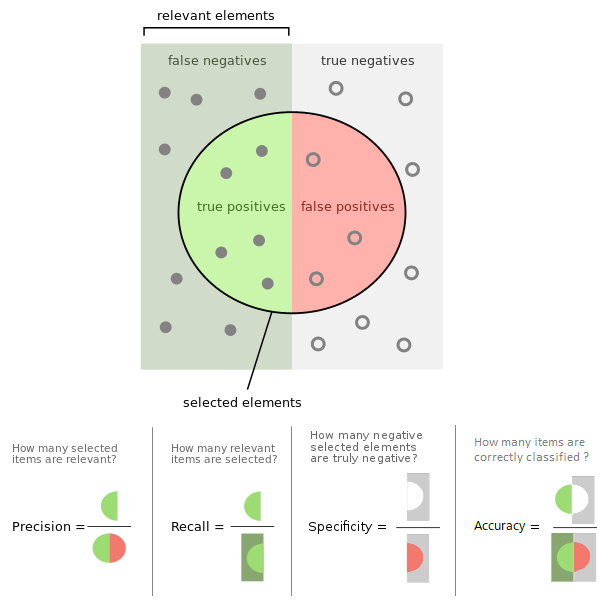

### LOGISTIC REGRESSION

I'll first create a dataframe that will register the words of the bag of words created with the tf-idf vectorizer. We will later complete this dataframe with the importance of each words for a specific subgenre.

In [ ]:
words_list = vectorizer.get_feature_names()
importance_df = pd.DataFrame()
importance_df["Words"] = words_list

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
# import pickle

In [ ]:
# Creating null matrix that will recieve the predictions of each model
prd_proba = np.zeros((X_val.shape[0],y.shape[1]))
prd = np.zeros((X_val.shape[0],y.shape[1]))


i = 0
for sf_col in sf_cols:
    lr = LogisticRegression(C=3,random_state = 0,class_weight = 'balanced')
    # C :Inverse of regularization strength; must be a positive float. Like in support vector machines,
    #   smaller values specify stronger regularization.
    
    # The “balanced” mode make the error of the underrepresented subgenre weight more
    # n_samples / (n_classes * np.bincount(y)).
    lr.fit(X_train,y_train.iloc[:, i])
    lr.predict(X_val)
    print(sf_col)
    
#     filename = "lr_" + re.search("(\()(.*)(\))", sf_col)[2].replace(" ", "_") +"2" +".sav"
#     print(filename)
#     # save the model to disk
#     pickle.dump(lr, open(filename, 'wb'))
#     text = vectorizer.transform(text_dystopia)

#     print(lr.predict_proba(text))
    
    prd_proba[:,i] = lr.predict_proba(X_val)[:,1]  
    prd[:,i] = lr.predict(X_val)
    
    print("Accuracy = ",accuracy_score(y_val[sf_col],prd[:,i]))
    print("F1 = ",f1_score(y_val[sf_col],prd[:,i], average="micro"))
    print("Hamming loss = ",hamming_loss(y_val[sf_col],prd[:,i]))
    print("\n")
    
    ## Cross val
    #scores = cross_val_score(lr, X_train, y_train.iloc[:, i], cv=5)
    #print('Cross-Validation Accuracy Scores', scores)
    
    # Getting the importance of each word in the decisions of the model
    words_importances = lr.coef_[0]
    importance_df[sf_col] = words_importances
    
    i += 1

In [ ]:
print("Accuracy = ",accuracy_score(y_val,prd))
print("Recall = ", recall_score(y_val,prd, average="micro"))
print("F1 = ",f1_score(y_val,prd, average="micro"))
print("Hamming loss = ",hamming_loss(y_val,prd))
print('AUC ROC score is ', roc_auc_score(y_val,prd_proba))

In [ ]:
all_models_results = pd.DataFrame(columns=['Model', 'Accuracy', 'F1', 'Hamming_loss', 'AUC_ROC'])

In [ ]:
lr_result = ["Logistic Regression", accuracy_score(y_val,prd), f1_score(y_val,prd, average="micro"), hamming_loss(y_val,prd), roc_auc_score(y_val,prd_proba)]
all_models_results.loc[0] = lr_result
all_models_results


#### Evaluating each binary classifier independently

In [ ]:

accuracy_list=[]
f1_list=[]
hl_list=[]
auc_list=[]

for i in range(0,10):
    accuracy_list.append(accuracy_score(y_val.iloc[:,i],prd[:,i]))
    f1_list.append(f1_score(y_val.iloc[:,i],prd[:,i], average="micro"))
    hl_list.append(hamming_loss(y_val.iloc[:,i],prd[:,i]))
    auc_list.append(roc_auc_score(y_val.iloc[:,i],prd_proba[:,i]))
    

In [ ]:
np.array(accuracy_list).mean()

In [ ]:
lr_result = ["Logistic Regression_binary_class", np.array(accuracy_list).mean(), np.array(f1_list).mean(), np.array(hl_list).mean(), np.array(auc_list).mean()]
all_models_results.loc[1] = lr_result
all_models_results

#### Exploring the feature importance of our binary classifiers

In [ ]:
importance_df

In [ ]:
fig=go.Figure()
fig.layout.xaxis.fixedrange = True
fig.layout.yaxis.fixedrange = True

fig.update_layout(title_text="TOP 30 Feature Importances")


buttons=[]

default_state = "Science Fiction (Dystopia) "

for sf_col in sf_cols:
    test_df = importance_df.sort_values(by=sf_col, ascending=False)[:30]
    subgenre_importance = test_df[["Words", sf_col]].copy()
    
    # We have two traces we're plotting per state: a boxplot of the submission quartiles, and a line with the current data to-date
    fig.add_trace(go.Bar(x=subgenre_importance["Words"], y=subgenre_importance[sf_col], visible=(sf_col==default_state)))

    
for sf_col in sf_cols:
    buttons.append(dict(method='update',
                        label=sf_col,
                        args = [{'visible': [sf_col==r for r in sf_cols]}]))

# Add dropdown menus to the figure
fig.update_layout(showlegend=False, updatemenus=[{"buttons": buttons, "direction": "down", "active": sf_cols.index(default_state), "showactive": True, "x": 1, "y": 1.15}])
fig.show()

In [ ]:
fig=go.Figure()
fig.layout.xaxis.fixedrange = True
fig.layout.yaxis.fixedrange = True

fig.update_layout(title_text="FLOP 30 Feature Importances")


buttons=[]

default_state = "Science Fiction (Dystopia) "

for sf_col in sf_cols:
    test_df = importance_df.sort_values(by=sf_col, ascending=True)[:30]
    subgenre_importance = test_df[["Words", sf_col]].copy()
    
    # We have two traces we're plotting per state: a boxplot of the submission quartiles, and a line with the current data to-date
    fig.add_trace(go.Bar(x=subgenre_importance["Words"], y=subgenre_importance[sf_col], visible=(sf_col==default_state)))
    fig.update_traces(marker_color='red')

    
for sf_col in sf_cols:
    buttons.append(dict(method='update',
                        label=sf_col,
                        args = [{'visible': [sf_col==r for r in sf_cols]}]))

# Add dropdown menus to the figure
fig.update_layout(showlegend=False, updatemenus=[{"buttons": buttons, "direction": "down", "active": sf_cols.index(default_state), "showactive": True, "x": 1, "y": 1.15}])
fig.show()

#### Optimizing the probabilistic model with a probability threshold

In [ ]:
from sklearn.metrics import recall_score

th = []
f = []
ham = []
ac = []
rec = []

# We make iterations to discover the best threshold value
# Threshold says how to distinguish between 0/1 label assignment.
for t in range (5,70): # threshold value
 y_pred_new = (prd_proba >= t/100).astype(int)
#  print("t =" ,t/100)
#  print("Accuracy = ",accuracy_score(y_val,y_pred_new))
#  print("F1 = ",f1_score(y_val,y_pred_new, average="micro"))
#  print("Hamming loss = ",hamming_loss(y_val,y_pred_new))
 th.append(t)
 ac.append(accuracy_score(y_val,y_pred_new))
 f.append(f1_score(y_val,y_pred_new, average="micro"))
 ham.append(hamming_loss(y_val,y_pred_new))
 rec.append(recall_score(y_val,y_pred_new, average="micro"))
plt.rcParams["figure.figsize"] = (12,6)
with plt.style.context('ggplot'):
 plt.plot(th, f)
 plt.plot(th, ham)
 plt.plot(th, ac)
 plt.plot(th,rec)
 plt.legend(['F1', 'Hamming loss', 'Accuracy', 'Recall'], loc='center left', fontsize = 14)
 plt.ylabel("metrics", fontsize = 14)
 plt.xlabel("probability threshold", fontsize = 14)
 plt.title("Logistic Regression Model", fontsize = 18)
plt.show()

### Classic Multi Label Text Classification methods

### Label Powerset
This method is one of the least used in the field but it has some advantages.

>Label Powerset is a problem transformation approach to multi-label classification that transforms a multi-label problem to a multi-class problem with 1 multi-class classifier trained on all unique label combinations found in the training data.

>The method maps each combination to a unique combination id number, and performs multi-class classification using the classifier as multi-class classifier and combination ids as classes.

The advantage of this method is that it is the only one that enable us to make a ranking between the labels.

On the other hand, this method has several drawbacks:

* The problem with this technique is its computational complexity (for instance, on our dataset, it is very long to compute).
* This cannot predict unseen labels (the model naturally overfits).

https://www.youtube.com/watch?v=g1xUgdCozJ8

In [ ]:
# #Label Powerset
# lp_classifier = LabelPowerset(LogisticRegression())
# lp_classifier.fit(X_train, y_train)
# lp_predictions = lp_classifier.predict(X_val)
# print("Accuracy = ",accuracy_score(y_val,lp_predictions))
# print("F1 score = ",f1_score(y_val,lp_predictions, average="micro"))
# print("Hamming loss = ",hamming_loss(y_val,lp_predictions))
# print('AUC ROC score is ', roc_auc_score(y_val,lp_classifier.predict_proba(X_val).toarray()))

We will not compute it because it would take too much time (approximately 40 min), but here are the results:

`````
Accuracy =  0.6025477707006369
F1 score =  0.7352309344790549
Hamming loss =  0.06280254777070064
AUC ROC score is  0.9611438821255189
`````

In [ ]:
lp_result = ["Label Powerset", 0.6025477707006369, 0.7352309344790549, 0.06280254777070064, 0.9611438821255189]
all_models_results.loc[2] = lp_result
all_models_results

### Multilabel k Nearest Neighbours
MLkNN module uses kNN classification method adapted for multi-label classification.
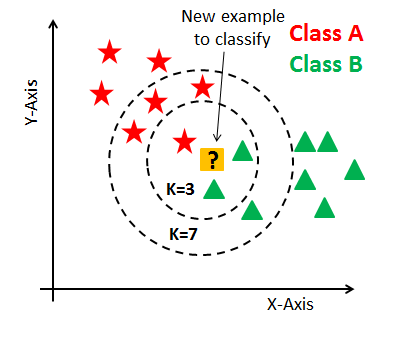

MLkNN builds uses k-NearestNeighbors find nearest examples to a test class and uses Bayesian inference to select assigned labels.
>Bayesian inference is a method of statistical inference in which Bayes' theorem is used to update the probability for a hypothesis as more evidence or information becomes available.

Advantages:
- Often a better accuracy than other methods
- Correlations between labels are considered

Drawbacks:
- Data distributions for some labels are unbalanced


In [ ]:
# # #MLkNN
# ml_classifier = MLkNN(k=10)
# # to prevent errors when handling sparse matrices.
# X_train = lil_matrix(X_train).toarray()
# y_train = lil_matrix(y_train).toarray()
# X_val = lil_matrix(X_val).toarray()
# y_val = lil_matrix(y_val).toarray()
# ml_classifier.fit(X_train, y_train)
# # predict
# ml_predictions = ml_classifier.predict(X_val)
# # accuracy metrics
# print("Accuracy = ",accuracy_score(y_val,ml_predictions))
# print("F1 score = ",f1_score(y_val,ml_predictions, average="micro"))
# print("Hamming loss = ",hamming_loss(y_val,ml_predictions))
# print("AUC ROC = ", roc_auc_score(y_val, ml_classifier.predict_proba(X_val).toarray()))

````````
Accuracy =  0.4732484076433121
F1 score =  0.653293575494714
Hamming loss =  0.08146496815286625
AUC ROC =  0.8549072590225327
````````

In [ ]:
mlknn_result = ["Multi KNN", 0.4732484076433121, 0.653293575494714, 0.08146496815286625, 0.8549072590225327]
all_models_results.loc[3] = mlknn_result
all_models_results

### Classifier Chain

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, test_size=0.20, shuffle=True)

Classifier chains is a machine learning method for problem transformation in multi-label classification. It combines the computational efficiency of the Binary Relevance method while still being able to take the label dependencies into account for classification.

Each model makes a prediction in the order specified by the chain using all of the available features provided to the model plus the predictions of models that are earlier in the chain.

* A chain of binary classifiers C0, C1, . . . , Cn is constructed, where a classifier Ci uses the predictions of all the classifier Cj , where j < i. This way the method, also called classifier chains (CC), can take into account label correlations.
* The total number of classifiers needed for this approach is equal to the number of classes, but the training of the classifiers is more involved.
* Following is an illustrated example with a classification problem of three categories {C1, C2, C3} chained in that order.

Advantages :
- label correlation taken into consideration 
- acceptable computational complexity 

Drawbacks :
- accuracy heavily depends on the order
- for n labels there are n! possible orders 
https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff

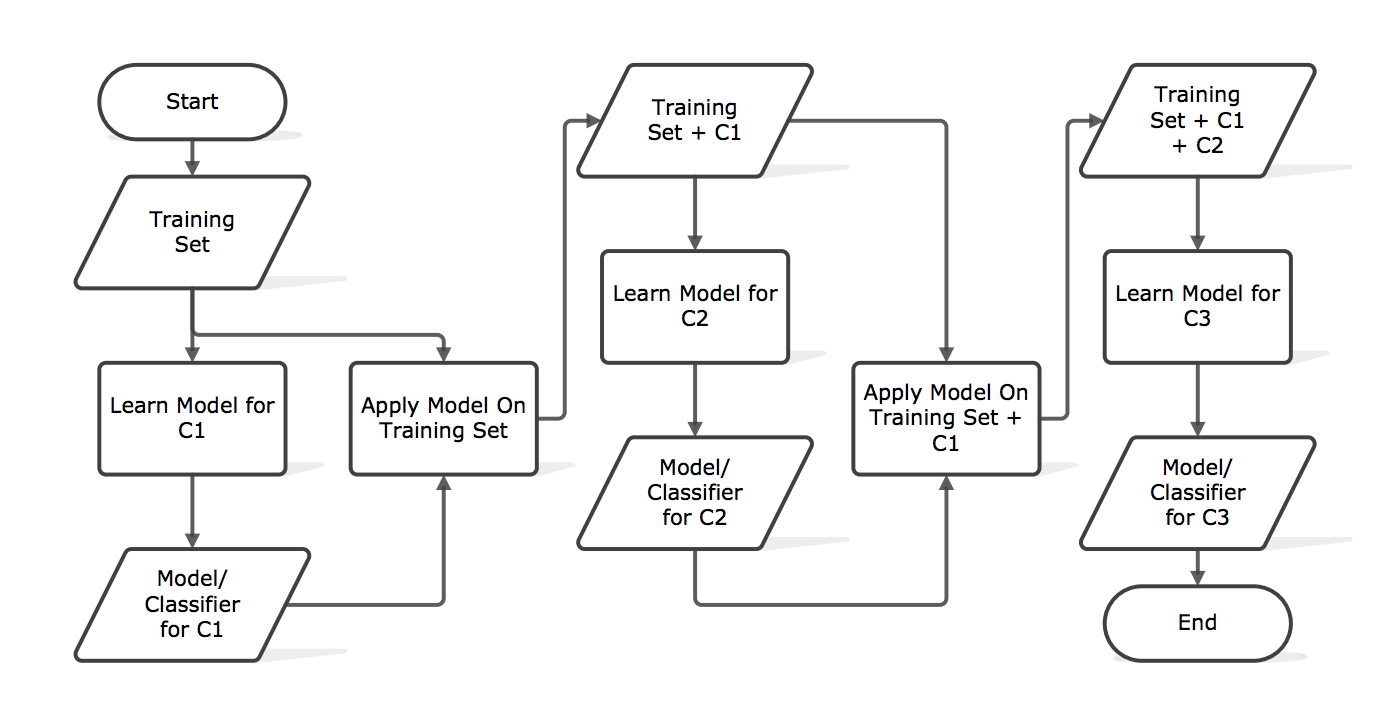

In [ ]:

#for the next classifier we need to remove from y-train, y-test categories which equal 0 for all train samples
selected_labels = y_train.columns[y_train.sum(axis = 0, skipna = True) > 0].tolist()
y_train = y_train.filter(selected_labels, axis=1)
y_val = y_val.filter(selected_labels, axis=1)

cc_classifier = ClassifierChain(LogisticRegression(C=3,random_state = 0, class_weight="balanced", solver="saga"))
cc_classifier.fit(X_train, y_train)
cc_predictions_proba = cc_classifier.predict_proba(X_val)
#for plotting metrics as a function of threashold
th = []
f = []
ham = []
ac = []

# We make iterations to discover the best threshold value
# Threshold says how to distinguish between 0/1 label assignment.
for t in range (5,70): # threshold value
 y_pred_new = (cc_predictions_proba >= t/100).astype(int)
#  print("t =" ,t/100)
#  print("Accuracy = ",accuracy_score(y_val,y_pred_new))
#  print("F1 = ",f1_score(y_val,y_pred_new, average="micro"))
#  print("Hamming loss = ",hamming_loss(y_val,y_pred_new))
 th.append(t)
 ac.append(accuracy_score(y_val,y_pred_new))
 f.append(f1_score(y_val,y_pred_new, average="micro"))
 ham.append(hamming_loss(y_val,y_pred_new))
plt.rcParams["figure.figsize"] = (12,6)
with plt.style.context('ggplot'):
 plt.plot(th, f)
 plt.plot(th, ham)
 plt.plot(th, ac)
 plt.legend(['F1', 'Hamming loss', 'Accuracy'], loc='center left', fontsize = 14)
 plt.ylabel("metrics", fontsize = 14)
 plt.xlabel("threshold", fontsize = 14)
 plt.title("Classfier Chain Model", fontsize = 18)
plt.show()

In [ ]:
y_pred_new = (cc_predictions_proba >= 61/100).astype(int)
print("Accuracy = ",accuracy_score(y_val,y_pred_new))
print("F1 = ",f1_score(y_val,y_pred_new, average="micro"))
print("Hamming loss = ",hamming_loss(y_val,y_pred_new))
print("AUC ROC = ", roc_auc_score(y_val, cc_predictions_proba.toarray()))


In [ ]:
cc_result = ["Classifier Chain", accuracy_score(y_val,y_pred_new), f1_score(y_val,y_pred_new, average="micro"), hamming_loss(y_val,y_pred_new), roc_auc_score(y_val, cc_predictions_proba.toarray())]
all_models_results.loc[4] = cc_result
all_models_results

In [ ]:
# import pickle
# filename = "cc.sav"
# pickle.dump(cc_classifier, open(filename, 'wb'))

### One VS Rest CLassifier (same as One vs All)
With One vs Rest classifier we make a binary classification of each class (considered our first class) vs. all the other class grouped together (considered our second class)
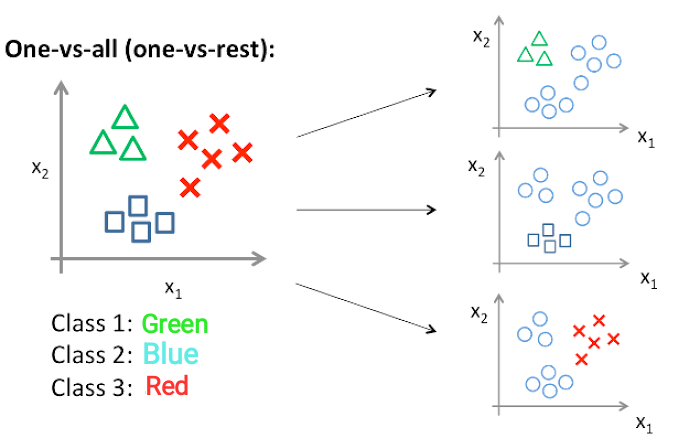
Explanation of the model here : https://www.youtube.com/watch?v=V8fS0T_ktn4

#### One vs. Rest with Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier


LR_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(C= 3, class_weight='balanced', solver='sag'), n_jobs=-1))])
accuracy = 0
f1 = 0
hl = 0
auc_roc = 0
for category in sf_cols[:]:
#     print('**Processing {} titles...**'.format(category))
    
    # Training logistic regression model on train data
    LR_pipeline.fit(X_train, y_train[category])
    
    # calculating test accuracy
    prediction = LR_pipeline.predict(X_val)
    accuracy = accuracy + accuracy_score(y_val[category],prediction)
    f1 = f1 + f1_score(y_val[category],prediction, average="micro")
    hl = hl + hamming_loss(y_val[category],prediction)
    auc_roc = auc_roc + roc_auc_score(y_val[category], prediction)
#     print("Accuracy = ",accuracy_score(y_val[category],prediction))
#     print("F1 = ",f1_score(y_val[category],prediction, average="micro"))
#     print("Hamming loss = ",hamming_loss(y_val[category],prediction))
#     print('AUC-ROC is {}'.format(roc_auc_score(y_val[category],prediction)))
#     print("\n")

print('Test averaged Accuracy is {}'.format(accuracy/len(sf_cols[:])))
print('Test averaged F1 is {}'.format(f1/len(sf_cols[:])))
print('Test averaged Hamming Loss is {}'.format(hl/len(sf_cols[:])))
print('Test averaged AUC-ROC is {}'.format(auc_roc/len(sf_cols[:])))

In [ ]:
ovr_lr_result = ["One vs. Rest (LR)", accuracy/len(sf_cols[:]), f1/len(sf_cols[:]), hl/len(sf_cols[:]), auc_roc/len(sf_cols[:])]
all_models_results.loc[5] = ovr_lr_result
all_models_results

#### One vs. Rest with Linear SVC

In [ ]:
from sklearn.svm import LinearSVC

SVC_pipeline = Pipeline([('clf', OneVsRestClassifier(LinearSVC(class_weight="balanced"), n_jobs=1))])

accuracy = 0
f1 = 0
hl = 0
auc_roc = 0

for category in sf_cols[:]:
#     print('**Processing {} titles...**'.format(category))
    
    # Training logistic regression model on train data
    SVC_pipeline.fit(X_train, y_train[category])
    
    # calculating test accuracy
    prediction = SVC_pipeline.predict(X_val)
    accuracy = accuracy + accuracy_score(y_val[category],prediction)
    f1 = f1 + f1_score(y_val[category],prediction, average="micro")
    hl = hl + hamming_loss(y_val[category],prediction)
    auc_roc = auc_roc + roc_auc_score(y_val[category], prediction)
#     print("Accuracy = ",accuracy_score(y_val[category],prediction))
#     print("F1 = ",f1_score(y_val[category],prediction, average="micro"))
#     print("Hamming loss = ",hamming_loss(y_val[category],prediction))
#     print('AUC-ROC is {}'.format(roc_auc_score(y_val[category],prediction)))
#     print("\n")

print('Test averaged Accuracy is {}'.format(accuracy/len(sf_cols[:])))
print('Test averaged F1 is {}'.format(f1/len(sf_cols[:])))
print('Test averaged Hamming Loss is {}'.format(hl/len(sf_cols[:])))
print('Test averaged AUC-ROC is {}'.format(auc_roc/len(sf_cols[:])))

In [ ]:
ovr_lsvc_result = ["One vs. Rest (LSVC)", accuracy/len(sf_cols[:]), f1/len(sf_cols[:]), hl/len(sf_cols[:]), auc_roc/len(sf_cols[:])]
all_models_results.loc[6] = ovr_lsvc_result
all_models_results

#### One vs. Rest with Random Forest Classifier

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

RF_pipeline = Pipeline([('clf', OneVsRestClassifier(RandomForestClassifier(), n_jobs=1))])

accuracy = 0
f1 = 0
hl = 0
auc_roc = 0

for category in sf_cols[:]:
#     print('**Processing {} titles...**'.format(category))
    
    # Training logistic regression model on train data
    RF_pipeline.fit(X_train, y_train[category])
    
    # calculating test accuracy
    prediction = RF_pipeline.predict(X_val)
    accuracy = accuracy + accuracy_score(y_val[category],prediction)
    f1 = f1 + f1_score(y_val[category],prediction, average="micro")
    hl = hl + hamming_loss(y_val[category],prediction)
    auc_roc = auc_roc + roc_auc_score(y_val[category], prediction)
#     print("Accuracy = ",accuracy_score(y_val[category],prediction))
#     print("F1 = ",f1_score(y_val[category],prediction, average="micro"))
#     print("Hamming loss = ",hamming_loss(y_val[category],prediction))
#     print('AUC-ROC is {}'.format(roc_auc_score(y_val[category],prediction)))
#     print("\n")

print('Test averaged Accuracy is {}'.format(accuracy/len(sf_cols[:])))
print('Test averaged F1 is {}'.format(f1/len(sf_cols[:])))
print('Test averaged Hamming Loss is {}'.format(hl/len(sf_cols[:])))
print('Test averaged AUC-ROC is {}'.format(auc_roc/len(sf_cols[:])))

In [ ]:
ovr_rf_result = ["One vs. Rest (RF)", accuracy/len(sf_cols[:]), f1/len(sf_cols[:]), hl/len(sf_cols[:]), auc_roc/len(sf_cols[:])]
all_models_results.loc[7] = ovr_rf_result
all_models_results

### Binary Relevance

Transforms a multi-label classification problem with L labels into L single-label separate binary classification problems using the same base classifier provided in the constructor. The prediction output is the union of all per label classifiers

The problem with binary relevnce is that it doesn't take label dependency into account.

https://www.youtube.com/watch?v=vnObmjMWVd0

In [ ]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB

classifier = BinaryRelevance(GaussianNB())
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_val)
accuracy_score(y_val,predictions)
print("Accuracy = ",accuracy_score(y_val,predictions.toarray()))
print("F1 = ",f1_score(y_val,predictions.toarray(), average="micro"))
print("Hamming loss = ",hamming_loss(y_val,predictions.toarray()))
print('AUC ROC is {}'.format(roc_auc_score(y_val,predictions.toarray())))

In [ ]:
br_result = ["Binary Relevance", accuracy_score(y_val,predictions.toarray()), f1_score(y_val,predictions.toarray(), average="micro"), hamming_loss(y_val,predictions.toarray()), roc_auc_score(y_val,predictions.toarray())]
all_models_results.loc[8] = br_result
all_models_results

### BERT Model

🤗 Transformers provides thousands of pretrained models to perform tasks on texts such as classification, information extraction, question answering, summarization, translation, text generation, etc in 100+ languages. Its aim is to make cutting-edge NLP easier to use for everyone.

🤗 Transformers provides APIs to quickly download and use those pretrained models on a given text, fine-tune them on your own datasets then share them with the community on our model hub. At the same time, each python module defining an architecture can be used as a standalone and modified to enable quick research experiments.

🤗 Transformers is backed by the two most popular deep learning libraries, PyTorch and TensorFlow, with a seamless integration between them, allowing you to train your models with one then load it for inference with the other.

https://github.com/huggingface/transformers

In [ ]:
X_bert = sf_full['Book_Description']

In [ ]:
y

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_bert.values, y['Space (Space Opera) '].values, random_state=0, test_size=0.20, shuffle=True)

SETTING UP THE GPU IF POSSIBLE

In [ ]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

In [ ]:
    import torch
    torch.cuda.empty_cache()

#### Installing the Hugging Face Library

In [ ]:
# !pip install transformers

To use Transformers, we need to:

1. Add special tokens to the start and end of each sentence.
2. Pad & truncate all sentences to a single constant length.
3. Explicitly differentiate real tokens from padding tokens with the “attention mask”.

In [ ]:
import re
def text_preprocessing(text):
    text = re.sub(r'(@.*?)[\s]', ' ', text)
    text = re.sub(r'[0-9]+' , '' ,text)
    text = re.sub(r'\s([@][\w_-]+)', '', text).strip()
    text = re.sub(r'&amp;', '&', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.replace("#" , " ")
    encoded_string = text.encode("ascii", "ignore")
    decode_string = encoded_string.decode()
    return decode_string

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
def preprocessing_for_bert(data):
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            truncation = True,
            return_attention_mask=True      # Return attention mask
            )
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    
    return input_ids, attention_masks


In [ ]:
MAX_LEN = 300

token_ids = list(preprocessing_for_bert([X_bert.values[0]])[0].squeeze().numpy())
print('Original: ', X_bert.values[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)


In [ ]:

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [ ]:
%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        # self.LSTM = nn.LSTM(D_in,D_in,bidirectional=True)
        # self.clf = nn.Linear(D_in*2,2)

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            # nn.LSTM(D_in,D_in)
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]
        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [ ]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
            #b_labels = b_labels.long().squeeze(1)
            #p#rint(b_labels)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            #loss = criterion(logits, target)
            loss = loss_fn(logits, b_labels.long())
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels.long())
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()
        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy 

In [ ]:
import gc
#del variables
gc.collect()

In [ ]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

In [ ]:
import torch.nn.functional as F

In [ ]:
def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    print("F1 = ",f1_score(y_true, y_pred, average="micro"))
    print("Hamming loss = ",hamming_loss(y_true, y_pred))
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
probs = bert_predict(bert_classifier, val_dataloader)
evaluate_roc(probs, y_val)


### Save the models

In [ ]:
# PATH = 'bert_spaceopera_2.pth'

In [ ]:
# torch.save(bert_classifier, PATH)

In [ ]:
#      from IPython.display import FileLink
#      FileLink(r'bert_spaceopera_2.pth')

### Test the model

In [ ]:
sf_cols

In [ ]:
PATHS = ['../input/bert-models-sf-books/bert_dystopia.pth','../input/bert-models-sf-books/bert_timetravel.pth','../input/bert-models-sf-books/bert_cyberpunk.pth','../input/bert-models-sf-books/bert_robots.pth','../input/bert-models-sf-books/bert_aliens.pth','../input/bert-models-sf-books/bert_apocalyptic.pth','../input/bert-models-sf-books/bert_alternatehistory.pth','../input/bert-models-sf-books/bert_steampunk.pth','../input/bert-models-sf-books/bert_militarysf.pth','../input/bert-models-sf-books/bert_spaceopera.pth']

In [ ]:
# Creating null matrix that will recieve the predictions of each model
prd = np.zeros((X_val.shape[0],y.shape[1]))
prd_proba = np.zeros((X_val.shape[0],y.shape[1]))

i=0

for PATH in PATHS:
    gc.collect()
    model = torch.load(PATHS[i])
    model.eval()

    probs = bert_predict(model, val_dataloader)

    preds = probs[:,1]
    prd_proba[:,i] = preds
    prd[:,i] = np.where(preds >= 0.5, 1, 0)
    gc.collect()
#     print(i)
    i += 1



In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0, test_size=0.20, shuffle=True)

In [ ]:
print("Accuracy = ",accuracy_score(y_val,prd))
print("F1 = ",f1_score(y_val,prd, average="micro"))
print("Hamming loss = ",hamming_loss(y_val,prd))
print('AUC ROC score is ', roc_auc_score(y_val,prd_proba))

In [ ]:
th = []
f = []
ham = []
ac = []
rec = []

# We make iterations to discover the best threshold value
# Threshold says how to distinguish between 0/1 label assignment.
for t in range (5,90): # threshold value
 y_pred_new = (prd_proba >= t/100).astype(int)
#  print("t =" ,t/100)
#  print("Accuracy = ",accuracy_score(y_val,y_pred_new))
#  print("F1 = ",f1_score(y_val,y_pred_new, average="micro"))
#  print("Hamming loss = ",hamming_loss(y_val,y_pred_new))
 th.append(t)
 ac.append(accuracy_score(y_val,y_pred_new))
 f.append(f1_score(y_val,y_pred_new, average="micro"))
 ham.append(hamming_loss(y_val,y_pred_new))
 rec.append(recall_score(y_val,y_pred_new, average="micro"))
plt.rcParams["figure.figsize"] = (12,6)
with plt.style.context('ggplot'):
 plt.plot(th, f)
 plt.plot(th, ham)
 plt.plot(th, ac)
 plt.plot(th,rec)
 plt.legend(['F1', 'Hamming loss', 'Accuracy', 'Recall'], loc='center left', fontsize = 14)
 plt.ylabel("metrics", fontsize = 14)
 plt.xlabel("threshold", fontsize = 14)
 plt.title("Classfier Chain Model", fontsize = 18)
plt.show()

In [ ]:
filtered_prd = (prd_proba >= 70/100).astype(int)
bert_result = ["Bert Model_overall", accuracy_score(y_val,filtered_prd), f1_score(y_val,filtered_prd, average="micro"),  hamming_loss(y_val,filtered_prd), roc_auc_score(y_val,prd_proba)]
all_models_results.loc[9] = bert_result
all_models_results

### For a text

In [ ]:
     from IPython.display import FileLink
     FileLink(r'bert_cyberpunk_2.pth')

In [ ]:
# text = text_cyberpunk

# paths = ['bert_timetravel.pth', 'bert_dystopia.pth', 'bert_cyberpunk.pth']

# for path in paths:
#     print (path)


#     # Model class must be defined somewhere
#     model = torch.load(path)
#     model.eval()

#     tt_inputs, tt_masks  = preprocessing_for_bert(text_dystopia)
#     tt_inputs = tt_inputs.to(device)
#     tt_masks = tt_masks.to(device)
#     logits = model(tt_inputs, tt_masks)
#     print(F.softmax(logits, dim=1).cpu().detach().numpy()[:, 1][0])

## Results of BERT for different subgenres

### Dystopia:

``
AUC: 0.9286
Accuracy: 87.27%
F1 =  0.872680412371134
Hamming loss =  0.12731958762886597
``

### Time Travel:

``
AUC: 0.9665
Accuracy: 95.57%
F1 =  0.9556701030927836
Hamming loss =  0.0443298969072165
`` 

### Cyberpunk:
``
AUC: 0.9477
Accuracy: 94.95%
F1 =  0.9494845360824742
Hamming loss =  0.050515463917525774
``

### Robots:
``
AUC: 0.9584
Accuracy: 97.16%
F1 =  0.9716494845360825
Hamming loss =  0.028350515463917526
``

### Aliens:
``
AUC: 0.9584
Accuracy: 93.30%
F1 =  0.9329896907216495
Hamming loss =  0.06701030927835051
``

### Apocalyptic:
``
AUC: 0.9714
Accuracy: 96.44%
F1 =  0.9644329896907217
Hamming loss =  0.03556701030927835
``

### Alternate History:
``
AUC: 0.9531
Accuracy: 93.87%
F1 =  0.938659793814433
Hamming loss =  0.06134020618556701
``

### Steampunk:
``
AUC: 0.9683
Accuracy: 95.21%
F1 =  0.952061855670103
Hamming loss =  0.04793814432989691
``

### Military SF:
``
AUC: 0.9828
Accuracy: 96.55%
F1 =  0.9654639175257732
Hamming loss =  0.034536082474226806
``

### Space Opera:
``
AUC: 0.9726
Accuracy: 94.02%
F1 =  0.9402061855670103
Hamming loss =  0.05979381443298969
``



In [ ]:
# test_inputs, test_masks = preprocessing_for_bert(test_csv.comment_text)

# # Create the DataLoader for our test set
# test_dataset = TensorDataset(test_inputs, test_masks)
# test_sampler = SequentialSampler(test_dataset)
# test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

In [ ]:
test_average_accuracy = (87.27 + 95.57 + 94.95 + 97.16 + 93.30 + 96.44 + 93.87 + 95.21 + 96.55 + 94.02)/1000
test_average_auc = (0.9286 + 0.9665 + 0.9477 + 0.9584 + 0.9584 + 0.9714 + 0.9531 + 0.9683 + 0.9828 + 0.9726)/10
test_average_f1 = (0.872680412371134 + 0.9556701030927836 + 0.9494845360824742 + 0.9716494845360825 + 0.9329896907216495 + 0.9644329896907217 + 0.938659793814433 + 0.952061855670103 + 0.9654639175257732 + 0.9402061855670103)/10
test_average_hamming_loss = (0.12731958762886597 + 0.0443298969072165 + 0.050515463917525774 + 0.028350515463917526 + 0.06701030927835051 + 0.03556701030927835 + 0.06134020618556701 + 0.04793814432989691 + 0.034536082474226806 + 0.05979381443298969)/10

In [ ]:
bert_result = ["Bert Model_binary_class_mean", test_average_accuracy, test_average_f1,  test_average_hamming_loss, test_average_auc]
all_models_results.loc[10] = bert_result
all_models_results

## Trying the best models
We are going to try the MLkNN on texts it has never seen (new releases from 2021) on different categories:

In [ ]:
text_dystopia = ["To Health. To Life. To the Future. We are The Key. 'No touching today for a healthy tomorrow.' Elodie obeys The Key. Elodie obeys the rules. Elodie trusts in the system. At least, Elodie used to... Aidan is a rebel. Aidan doesn't do what he's told. Aidan just wants to be free. Aidan is on his last chance... After a pandemic wiped out most of the human race, The Key took power. The Key dictates the rules. They govern in order to keep people safe. But as Elodie and Aidan begin to discover there is another side to The Key, they realise not everything is as it seems. Rather than playing protector, The Key are playing God."]

text_time_travel = ["At the gates between worlds. In a war outside of time. They fight for us. The man they took prisoner was not the Jonathan Tibbs they remembered. He said that time was running out. That the world faced an enemy it could not defeat. He said everything depended on whether or not they could make a leap of faith. Then, he asked them for five nuclear warheads. The Never Army is the final installment in The Chronicles of Jonathan Tibbs -- a mind-bending, genre crossing, multiple award winning, action-adventure trilogy."]

text_cyberpunk = ["A corporate mercenary wakes in a reconstructed body, a beautiful woman by his side. Then Hosaka Corporation reactivates him, for a mission more dangerous than the one he’s recovering from: to get a defecting chief of R&D—and the biochip he’s perfected—out intact. But this proves to be of supreme interest to certain other parties—some of whom aren’t remotely human..."]

text_robots = ["The critically acclaimed author of the “bold, innovating, and thrilling” (Stephen King) novel The Twenty-Year Death and the “brilliant” (Booklist, starred review) novel Barren Cove returns with a dark and compelling mystery set in the near future. Decimated by plague, the human population is now a minority. Robots—complex AIs almost indistinguishable from humans—are the ruling majority. Nine months ago, in a controversial move, the robot government opened a series of preserves, designated areas where humans can choose to live without robot interference. Now the preserves face their first challenge: someone has been murdered. Chief of Police Jesse Laughton on the SoCar Preserve is assigned to the case. He fears the factions that were opposed to the preserves will use the crime as evidence that the new system does not work. As he digs for information, robots in the outside world start turning up dead from bad drug-like programs that may have originated on SoCar land. And when Laughton learns his murder victim was a hacker who wrote drug-programs, it appears that the two cases might be linked. Soon, it’s clear that the entire preserve system is in danger of collapsing. Laughton’s former partner, a robot named Kir, arrives to assist on the case, and they soon uncover shocking secrets revealing that life on the preserve is not as peaceful as its human residents claim. But in order to protect humanity’s new way of life, Laughton must solve this murder before it’s too late. The Preserve is a fresh and futuristic mystery that is perfect for fans of Westworld and Blade Runner."]

text_aliens = ["Peacetime can be a rough adjustment for the battle-hardened Merry Band of Pirates. Especially when aliens don’t get the memo that the shooting is over."]

text_apocalyptic = ["Raised in isolation at Heavenly Shepherd, her family’s trailer-dealership-turned-survival compound, Ami Miles knows that she was lucky to be born into a place of safety after the old world ended and the chaos began. But when her grandfather arranges a marriage to a cold-eyed stranger, she realizes that her “destiny” as one of the few females capable of still bearing children isn’t something she’s ready to face. With the help of one of her aunts, she flees the only life she’s ever known, and sets off on a quest to find her long-lost mother (and hopefully a mate of her own choosing). But as she journeys, Ami discovers many new things about the world... and about herself. "]

text_alternate_history = ["AN INSTANT NEW YORK TIMES BESTSELLER! Marie Benedict, the beloved New York Times bestselling author of The Only Woman in the Room, uncovers the untold story of Agatha Christie’s mysterious eleven day disappearance. In December 1926, Agatha Christie goes missing. Investigators find her empty car on the edge of a deep, gloomy pond, the only clues some tire tracks nearby and a fur coat left in the car—strange for a frigid night. Her husband and daughter have no knowledge of her whereabouts, and England unleashes an unprecedented manhunt to find the up-and-coming mystery author. Eleven days later, she reappears, just as mysteriously as she disappeared, claiming amnesia and providing no explanations for her time away. The puzzle of those missing eleven days has persisted. With her trademark exploration into the shadows of history, acclaimed author Marie Benedict brings us into the world of Agatha Christie, imagining why such a brilliant woman would find herself at the center of such a murky story. What is real, and what is mystery? What role did her unfaithful husband play, and what was he not telling investigators? A master storyteller whose clever mind may never be matched, Agatha Christie’s untold history offers perhaps her greatest mystery of all."]

text_hard_sf = ["Humanity is struggling to hold out against a hostile takeover by an alien race that claims to be on a religious mission to bring all sentient life to its God at the End of Time. But while things may look grim in the immediate aftermath of the attack, mankind is busy playing an even longer game than the aliens may have expected. Will a strategy millennia in the making finally be enough to defeat this seemingly unstoppable enemy? And what secrets are the aliens truly hiding in their most deeply protected stronghold?With his trademark optimism about humanity's tenacity and capacity for greatness, Peter F. Hamilton ends this brilliant saga with a bang--and reveals a few startling surprises along the way."]

text_steampunk = ["The letter was short. A name, a time, a place. Marion Lane and the Midnight Murder plunges readers into the heart of London, to the secret tunnels that exist far beneath the city streets. There, a mysterious group of detectives recruited for Miss Brickett’s Investigations & Inquiries use their cunning and gadgets to solve crimes that have stumped Scotland Yard. Late one night in April 1958, a filing assistant for Miss Brickett’s named Michelle White receives a letter warning her that a heinous act is about to occur. She goes to investigate but finds the room empty. At the stroke of midnight, she is murdered by a killer she can’t see—her death the only sign she wasn’t alone. It becomes chillingly clear that the person responsible must also work for Miss Brickett’s, making everyone a suspect. Almost unwillingly, Marion Lane, a first-year Inquirer-in-training, finds herself being drawn ever deeper into the investigation. When her friend and mentor is framed for the crime, to clear his name she must sort through the hidden alliances at Miss Brickett’s and secrets dating back to WWII. Masterful, clever and deliciously suspenseful, Marion Lane and the Midnight Murder is a fresh take on the Agatha Christie—style locked-room mystery with an exciting new heroine detective at the helm."]

text_military_sf = ["The battle against the Lankies has been won. Earth seems safe. Peacetime military? Not on your life. It’s been four years since Earth threw its full military prowess against the Lanky incursion. Humanity has been yanked back from the abyss of extinction. The solar system is at peace. For now. The future for Major Andrew Grayson of the Commonwealth Defense Corps and his wife, Halley? Flying desk duty on the front. No more nightmares of monstrous things. No more traumas to the mind and body. But when an offer comes down from above, Andrew has to make a choice: continue pushing papers into retirement, or jump right back into the fight? What’s a podhead to do? The remaining Lankies may have retreated in fear, but the threat isn’t over. They need to be wiped out for good before they strike again. That’ll take a new offensive deployment. Aboard an Avenger warship, Andrew and the special tactics team under his command embark on the ultimate search-and-destroy mission. This time, it’ll be on Lanky turf. No big heroics. No unnecessary risks. Just a swift hit-and-run raid in the hostile Capella system. Blow the alien seed ships into oblivion and get the hell back to Earth. At least, that’s the objective. But when does anything in war go according to plan?"]

text_space_opera = ['Queen Samara Rani knows she’s likely walking into a trap, but agreeing to meet with Commander Adams is the fastest way to get within striking distance of the Quint Confederacy’s biggest traitor and her sworn enemy. Adams attacked her home and destroyed her ship, and if he’s not stopped, he will ruin the tentative peace between the Kos Empire and the Quint Confederacy—and Samara’s chance at future with Emperor Valentin Kos. Samara is determined to serve up some well-deserved payback, but she is no longer a lone assassin, and despite her protests, her friends and allies refuse to let her undertake such a perilous mission without them. Even Valentin, usually the voice of reason, refuses to stay behind. Samara is loath to put her friends in danger, and taking a team carries its own risks, so she makes plans to keep them safe, no matter what the cost. When Adams threatens that safety, and everything she holds dear, Samara vows to show him exactly how she earned her deadly reputation—and why one should never cross the Rogue Queen.']

texts = [text_dystopia, text_time_travel, text_cyberpunk, text_robots, text_aliens, text_apocalyptic, text_alternate_history,  text_steampunk, text_military_sf, text_space_opera]

texts_category = ['dystopia', 'time_travel', 'cyberpunk', 'robots', 'aliens', 'apocalyptic', 'alternate_history', 'steampunk', 'military_sf', 'space_opera']


In [ ]:
#sf_full[sf_full.Book_Description.str.contains(text_space_opera[0])]

#### Label Powerset Test

In [ ]:

# n = 0

# for text in texts:
#     ### Give your book summary to the text variable:
    


#     text_vector = vectorizer.transform(text)
#     preds = lp_classifier.predict(text_vector).toarray()
    
#     print('Genre: ' + '\n' +  str(texts_category[n]) + '\n')
    
#     print('Description: ' + '\n' +  str(text[0]) + '\n')

#     i = 0
#     for col in sf_cols:
#         if preds[0][i] > 0:        
#             print(col + ": " + str(preds[0][i]))

#         if preds[0][i] == 0:        
#             print(col + ": " + str(preds[0][i]))


#         i =  i + 1
#     print('\n')
    
#     n += 1

#### Classifier Chain test

In [ ]:
n = 0
t=61

for text in texts:
    ### Give your book summary to the text variable:
    
    text_vector = vectorizer.transform(text)

    cc_predictions_proba = cc_classifier.predict_proba(text_vector)
    
    y_pred_new = (cc_predictions_proba >= t/100).astype(int)

    preds = y_pred_new.toarray()
    
    print('Genre: ' + '\n' +  str(texts_category[n]) + '\n')
    
    print('Description: ' + '\n' +  str(text[0]) + '\n')

    i = 0
    for col in sf_cols:
        if preds[0][i] > 0:        
            print(col + ": " + str(preds[0][i]))

        if preds[0][i] == 0:        
            print(col + ": " + str(preds[0][i]))


        i =  i + 1
    print('\n')
    
    print(preds[0][9])
    print(n)
    if preds[0][n] == 1:
        print('Main Genre detected', '\n')
    else:
        print('Missed the main genre', '\n')
        
    
    n += 1

#### One vs. Rest (LR)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, test_size=0.20, shuffle=True)

n = 0



for text in texts:
    ### Give your book summary to the text variable:
    LR_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(C= 3, class_weight='balanced', solver='sag'), n_jobs=-1))])
    
    text_vector = vectorizer.transform(text)
    
    preds = []
    
    for category in sf_cols[:]:
        #print('**Processing {} titles...**'.format(category))

        # Training logistic regression model on train data
        LR_pipeline.fit(X_train, y_train[category])

        # calculating test accuracy
        prediction = LR_pipeline.predict(text_vector)
        
        preds.append(int(prediction[0]))
    
        
    
    print('Genre: ' + '\n' +  str(texts_category[n]) + '\n')
    
    print('Description: ' + '\n' +  str(text[0]) + '\n')
    

    i = 0
    for col in sf_cols:
        if preds[i] > 0:        
            print(col + ": " + str(preds[i]))

        if preds[i] == 0:        
            print(col + ": " + str(preds[i]))


        i =  i + 1
    print('\n')
    
    if preds[n] == 1:
        print('Main Genre detected', '\n')
    else:
        print('Missed the main genre', '\n')
        
    
    n += 1

#### Bert Model

In [ ]:
j=0
for text in texts:
    i=0
    print(texts_category[j])
    tt_inputs, tt_masks  = preprocessing_for_bert(text)
    tt_inputs = tt_inputs.to(device)
    tt_masks = tt_masks.to(device)
    for PATH in PATHS:
        # # Model class must be defined somewhere
        model = torch.load(PATHS[i])
        model.eval()
        
        logits = model(tt_inputs, tt_masks)

        probs = F.softmax(logits, dim=1).cpu().detach().numpy()
        preds = probs[:, 1]
        y_pred = np.where(preds >= 0.5, 1, 0)
        print(sf_cols[i], y_pred)
        i += 1
    print("\n")
    j += 1

# Test it with your own text description ! 
I created a web application so that you can directly test it with your text and get more information about the project.
You may have to wait a little since the application goes to sleep when nobody uses it.

https://sf-books-analyser.herokuapp.com/